In [1]:
import requests
import lxml.html as lh
import numpy as np
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
import pandas as pd
import re
from datetime import datetime


In [247]:
#Function only returns data for the top league from region (As decided by itsrugby.com)
def league_year_stats(soup):
    count = 0
    result_array = []

    for result in soup.find_all('tr'):
        for result2 in result.find_all('td', attrs = {"align": "center", "id": "noir"}):
            if (count>7 and count <32):
                try:
                    result_array.append(float(result2.contents[0]))
                except: 
                    result_array.append(np.nan)
            count+=1
    return(result_array)
def league_stats(region_key, league_str):
    URL = 'https://www.itsrugby.co.uk/' + region_key + '.html'
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, 'html.parser')
    url_tails = []
    url_head = 'https://www.itsrugby.co.uk/'
    league_stats_dict = {'league': [], 'year': [], 'tries_avg': [], 'tries_nb': [], 'conv_avg': [], 'conv_nb': [], 'pen_avg': [], 'pen_nb': [], 'dg_avg': [], 'dg_nb': []}
    result_ind = [0,0, 1,0,7,6,13,12,19,18]
    for a_href in soup.find_all('a', href=True):
        if (str(a_href['href'])[0:7] == 'result-'):
            url_tails.append(str(a_href['href'])[6:])
    for i in range(len(url_tails)):
        URL = url_head + 'stats' + url_tails[i]
        page = requests.get(URL)
        soup = BeautifulSoup(page.text, "html.parser")
        year = URL[-9:-5]
        result_array = league_year_stats(soup)
        for k in range(8):
            try:
                league_stats_dict[list(league_stats_dict.keys())[k+2]].append(result_array[result_ind[k+2]])
            except IndexError: 
                league_stats_dict[list(league_stats_dict.keys())[k+2]].append(np.nan)
    
        league_stats_dict['year'].append(float(year))
        league_stats_dict['league'].append(league_str)
    return(pd.DataFrame.from_dict(league_stats_dict))

In [248]:
ml_leagues = ['englandpremiership', 'top14', 'superrugby', '6nationstournament', 'heinekencup']
archive_links = ['archives-irluk', 'archives-fr', 'archives-hemsud', 'archives-int', 'archives-cupeurope']
league_dataframes = []
for i in range(len(ml_leagues)):
    league_dataframes.append(league_stats(archive_links[i], ml_leagues[i]))
ml_stats_df = pd.concat(league_dataframes, ignore_index=True)
ml_stats_df = ml_stats_df.drop(ml_stats_df[(ml_stats_df.league == 'superrugby') & (ml_stats_df.year == '2019')].index)


In [249]:
ml_stats_df['games'] = ml_stats_df['tries_nb'] / ml_stats_df['tries_avg']
ml_stats_df['conv_rate'] = ml_stats_df['conv_avg'] / ml_stats_df['conv_avg']
ml_stats_df['tcp_avg'] = (ml_stats_df['tries_avg']*5) + (ml_stats_df['conv_avg']*2) + (ml_stats_df['pen_avg']*3)
ml_stats_df['tcp_nb'] = ml_stats_df['tcp_avg'] * ml_stats_df['games']

In [250]:
X = np.arange(ml_stats_df['year'].min(), ml_stats_df['year'].max() +1)
y_tries = ml_stats_df.groupby('year').sum()['tries_nb'] / ml_stats_df.groupby('year').sum()['games']
y_pen = ml_stats_df.groupby('year').sum()['pen_nb'] / ml_stats_df.groupby('year').sum()['games']
y_tcp = ml_stats_df.groupby('year').sum()['tcp_nb'] / ml_stats_df.groupby('year').sum()['games']
idx = np.isfinite(X) & np.isfinite(y_tries) & (X >= 2010)
tries_fit = np.polyfit(X[idx], y_tries[idx], 1)
idx = np.isfinite(X) & np.isfinite(y_pen) & (X >= 2010)
pen_fit = np.polyfit(X[idx], y_pen[idx], 1)
idx = np.isfinite(X) & np.isfinite(y_tcp) & (X >= 2010)
tcp_fit = np.polyfit(X[idx], y_tcp[idx], 1)


[ 1.57797637e-01 -3.13233803e+02] [-2.40407933e-01  4.88977958e+02]


In [251]:
y_tries_fit = X*tries_fit[0] + tries_fit[1]
y_pen_fit = X*pen_fit[0] + pen_fit[1]
y_tcp_fit = X*tcp_fit[0] + tcp_fit[1]


[1.572482   1.73027963 1.88807727 2.04587491 2.20367254 2.36147018
 2.51926782 2.67706545 2.83486309 2.99266073 3.15045836 3.308256
 3.46605364 3.62385127 3.78164891 3.93944655 4.09724418 4.25504182
 4.41283946 4.5706371  4.72843473 4.88623237 5.04403001 5.20182764
 5.35962528 5.51742292 5.67522055]


Text(0.5, 1.0, 'Points from Tries, Conversions, and Penalty Goals per Game Since 2010')

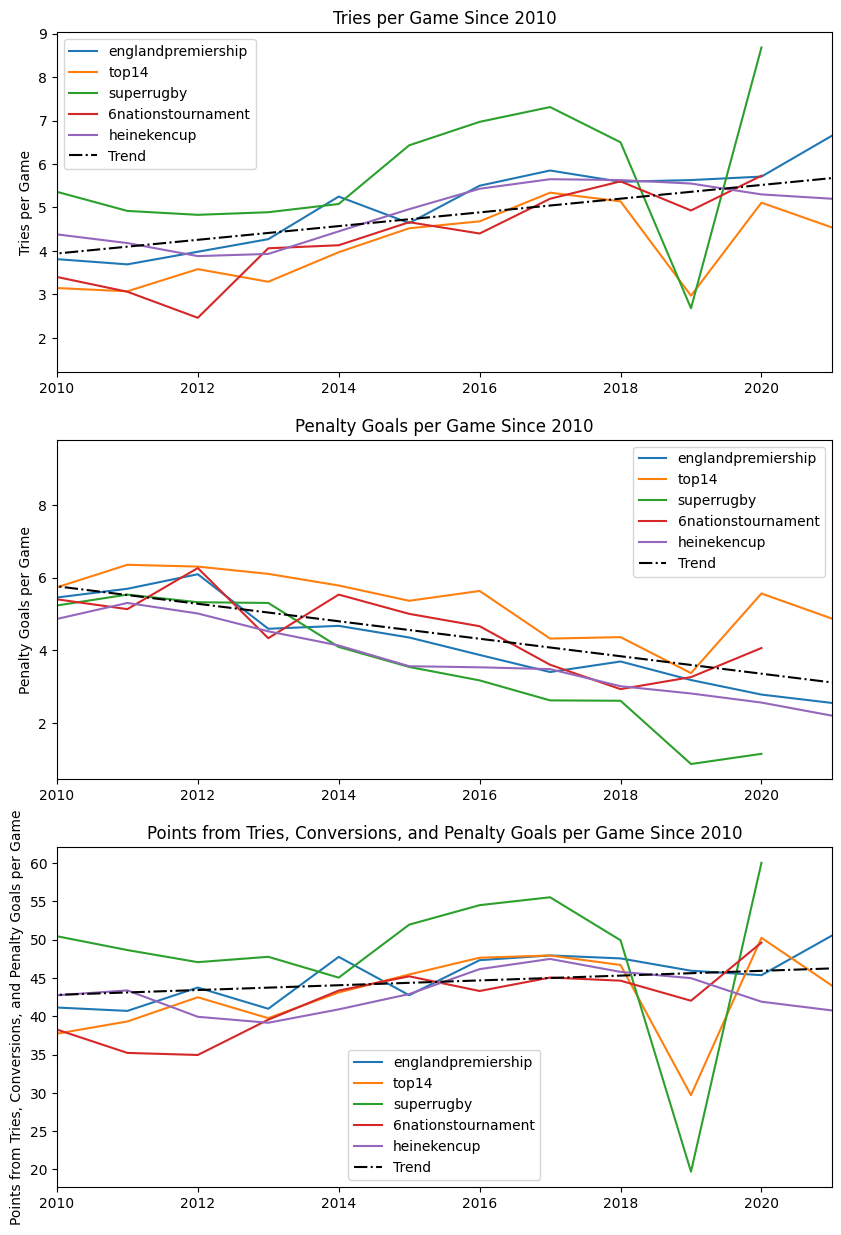

In [254]:

plt.figure(figsize=(10,15))
plt.subplot(3,1,1)
count = 2
for league in ml_leagues:
    plt.plot(ml_stats_df[ml_stats_df['league'] == league]['year'], ml_stats_df[ml_stats_df['league'] == league]['tries_avg'])
plt.plot(X, y_tries_fit, linestyle = '-.', color = 'black')
plt.legend(ml_leagues + list(['Trend']))
plt.xlim([2010, 2021])
plt.ylabel('Tries per Game')
plt.title('Tries per Game Since 2010')

plt.subplot(3,1,2)
count = 2
for league in ml_leagues:
    plt.plot(ml_stats_df[ml_stats_df['league'] == league]['year'], ml_stats_df[ml_stats_df['league'] == league]['pen_avg'])
plt.plot(X, y_pen_fit, linestyle = '-.', color = 'black')
plt.legend(ml_leagues + list(['Trend']))
plt.xlim([2010, 2021])
plt.ylabel('Penalty Goals per Game')
plt.title('Penalty Goals per Game Since 2010')

plt.subplot(3,1,3)
count = 2
for league in ml_leagues:
    plt.plot(ml_stats_df[ml_stats_df['league'] == league]['year'], ml_stats_df[ml_stats_df['league'] == league]['tcp_avg'])
plt.plot(X, y_tcp_fit, linestyle = '-.', color = 'black')
plt.legend(ml_leagues + list(['Trend']))
plt.xlim([2010, 2021])
plt.ylabel('Points from Tries, Conversions, and Penalty Goals per Game')
plt.title('Points from Tries, Conversions, and Penalty Goals per Game Since 2010')


In [ ]:
from bs4 import BeautifulSoup
leagues_10yr_stats = {}
years = ['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']
result_ind = [1,0,7,6,13,12,19,18]
result_stat = ['tries_avg', 'tries_nb', 'conv_avg', 'conv_nb', 'pen_avg', 'pen_nb', 'dg_avg', 'dg_nb']
for i in range(len(leagues)):
    league_stats = {'tries_avg': [], 'tries_nb': [], 'conv_avg': [], 'conv_nb': [], 'pen_avg': [], 'pen_nb': [], 'dg_avg': [], 'dg_nb': []}
    for j in range(len(years)):
        URL = 'https://www.itsrugby.co.uk/mutation-{league}-{year}.html'.format(league = league_name_arr[i,j], year = years[j])
        page = requests.get(URL)
        soup = BeautifulSoup(page.text, "html.parser")
        

In [50]:
leagues = ['top14', 'prod2', 'federale1', 'englandpremiership', 'unitedrugbychampionship', 'englandchampionship', 'superrugby', 'curriecupfirstdiv', 'urbatop13', 'japan', 'majorleaguerugby']
player_links = []
for i in range(len(leagues)):
    URL = 'https://www.itsrugby.co.uk/players/competitions/{}.html#'.format(leagues[i])
    page = requests.get(URL)
    soup = BeautifulSoup(page.text, "html.parser")
    for link in soup.findAll('a'):
        if(str(link.get('href'))[21:28] == 'players'):
            player_links.append(str(link.get('href'))[2:])

In [52]:
fp = open(r'player_link.txt', 'w')
for link in player_links:
    fp.write('{}\n'.format(link))
fp.close()

In [9]:
def player_data(URL):
    URL = 'https://' + URL
    page = requests.get(URL)
    soup = BeautifulSoup(page.text, "html.parser")
    count = 0
    result_array = []
    start = False
    stats_dict = {'player_id': [], 'birthdate': [], 'pos': [], 'year': [], 'team': [], 'competition': [], 'pts': [], 'played': [], 'start': [], 'try': [], 'pen': [], 'dp': [], 'tr': [], 'yellow': [], 'red': [], 'min': []}
    string = str(soup.find_all('span')[1].contents)
    split_string = string.split('xa0')
    pos = split_string[1][:-2]
    try:
        string2 = str(soup.find_all('p')[1])
        match = re.search(r'\d{2}/\d{2}/\d{4}', string2)
        bd = match.group(0)
    except:
        bd = np.nan
    tr_count = 0
    for result in soup.find_all('tr'):
        ##print('row', tr_count)
        tr_count += 1
        if((start) & ('tr class=\"itsBlue1\"' in str(result))):
            #print(str(result))
            break;
        #if(result.find_all('td')[0].contents[0] == 'Competitions'):
            #break;
        ##print('hi', str(result.find_all('td')[0]))
        if((start) & ('style=' in str(result.find_all('td')[0]))):
            stats_dict['year'].append(stats_dict['year'][-1])
            track = 1
        elif((start) & (str(result.find_all('td')[0].contents[0])[0] not in ['0', '1', '2', '9'])):
            stats_dict['year'].append(stats_dict['year'][-1])
            stats_dict['team'].append(stats_dict['team'][-1])
            ##print(str(result.find_all('td')[0].contents[0])[0])
            track = 4
        else:
            track = -1
        keys = list(stats_dict.keys())
        k = 7
        for result2 in result.find_all('td'):
            if(start):
                track += 1   
            #print('track', track)
            #print('count', count)
            #print(result2.contents)

            if(track == 0):
                if(len(str(result2.contents[0])) == 5):
                    stats_dict['year'].append(int('20' + result2.contents[0][:2]))
                else:
                    stats_dict['year'].append(int(str(result2.contents[0])))

            if(track == 2):
                a = result2.find('a').contents[0]
                stats_dict['team'].append(a)
            if(track == 5):
                ##print(result2.contents)
                stats_dict['competition'].append(result2.contents[0])
                stats_dict['player_id'].append(URL[35:-6])
                stats_dict['pos'].append(pos)
                stats_dict['birthdate'].append(bd)
                #dlkjasl = 0
            if(track == 7):
                if(result2.contents[0] == 'No data'):
                    ##print(result2.contents[0])
                    for i in range(len(keys[6:])):
                        stats_dict[keys[i+6]].append(np.nan)
                    break;
                else:
                    try:
                        stats_dict['pts'].append(float(result2.contents[0]))
                    except:
                        stats_dict['pts'].append(0.0)

            if((track > 7) & (track%2 !=0) & (track != 25)):
                try:
                    a = float(result2.find('a').contents[0])
                    stats_dict[keys[k]].append(a)
                except:
                    stats_dict[keys[k]].append(0.0)
                k += 1
        
            if(track == 25):
                a = result2.contents[0]
                try:
                    stats_dict['min'].append(float(a))
                except:
                    stats_dict['min'].append(0.0)
            if((count == 25) & (~start)):
                ##print(result2.contents[0])
                if(len(str(result2.contents[0])) == 5):
                    stats_dict['year'].append(int('20' + result2.contents[0][:2]))
                else:
                    stats_dict['year'].append(int(str(result2.contents[0])))
                start = True
                track += 1
        
            count += 1
    #print(stats_dict)
    return(pd.DataFrame.from_dict(stats_dict)) 
        

In [2]:
player_links = open('player_link.txt').readlines()


In [19]:
#Function works for all players with valid pages. 19 links do not have valid pages and are thus skipped
player_dfs = []
bad_players = []
count_success = 0
count_fail = 0
player_links_len = len(player_links)
for i in range(player_links_len):
    try:
        player_dfs.append(player_data(player_links[i][:-1]))
        count_success += 1
    except:
        bad_players.append(player_links[i][:-1])
        count_fail += 1
    #rint(i)
    if((i%100) == 0):
        print(str((i/player_links_len) * 100) + '%')
        print((count_fail / (count_fail + count_success))*100)
print('failed: ' + str(count_fail) + 'succeeded: ' + str(count_success))

NameError: name 'player_links' is not defined

In [11]:
players_df = pd.concat(player_dfs, ignore_index = True)

In [ ]:
compression_opts = dict(method='zip', archive_name='itsrugby_players.csv')
df.to_csv('itsrugby_players.zip', index=False, compression=compression_opts)

In [161]:
players_df = pd.read_csv('itsrugby_players.zip')

In [162]:
def age(row):
    birthdate = str(row['birthdate'])
    ref_year = row['year']
    ref_date =  '07/01/' + str(ref_year)
    ref_date = datetime.strptime(ref_date, '%d/%m/%Y')
    birthdate_strp = datetime.strptime(birthdate, '%d/%m/%Y')
    age = ref_date.year - birthdate_strp.year - ((ref_date.month, ref_date.day) < (birthdate_strp.month, birthdate_strp.day))
    return age

def prev_year_league(row, df):
    player_id = row['player_id']
    year = row['year']
    prev_year = df[(df['year'] - year == -1) & (df['player_id'] == player_id)]
    if(len(prev_year['competition']) > 1):
        prev_league = np.nan
    elif(len(prev_year['competition']) > 0):
        prev_league = np.array(prev_year['competition'])[0]
    else:
        prev_league = np.nan
    return prev_league

def prev_year_min(row, df):
    player_id = row['player_id']
    year = row['year']
    prev_year = df[(df['year'] - year == -1) & (df['player_id'] == player_id)]
    if(len(prev_year['competition']) > 1):
        prev_min = np.nan
    if(len(prev_year['min']) > 0):
        prev_min = np.array(prev_year['min'])[0]
    else:
        prev_min = np.nan
    return prev_min

def prev_year_played(row, df):
    player_id = row['player_id']
    year = row['year']
    prev_year = df[(df['year'] - year == -1) & (df['player_id'] == player_id)]
    if(len(prev_year['competition']) > 1):
        prev_played = np.nan
    if(len(prev_year['played']) > 0):
        prev_played = np.array(prev_year['played'])[0]
    else:
        prev_played = np.nan
    return prev_played

def prev_year_start(row, df):
    player_id = row['player_id']
    year = row['year']
    prev_year = df[(df['year'] - year == -1) & (df['player_id'] == player_id)]
    if(len(prev_year['competition']) > 1):
        prev_start = np.nan
    if(len(prev_year['start']) > 0):
        prev_start = np.array(prev_year['start'])[0]
    else:
        prev_start = np.nan
    return prev_start

def career_minutes(row, df):
    player_id = row['player_id']
    year = row['year']
    df_player = df[(df['player_id'] == player_id) & (df['year'] < year)]
    minutes = np.sum(np.array(df_player['min']))
    return minutes
    

def career_played(row, df):
    player_id = row['player_id']
    year = row['year']
    df_player = df[(df['player_id'] == player_id)& (df['year'] < year)]
    played = np.sum(np.array(df_player['played']))
    return played

def career_start(row, df):
    player_id = row['player_id']
    year = row['year']
    df_player = df[(df['player_id'] == player_id)& (df['year'] < year)]
    start = np.sum(np.array(df_player['start']))
    return start


In [163]:
players_df = players_df.dropna(axis=0)
players_df['age'] = players_df.apply(lambda row: age(row), axis=1)
players_df = players_df.drop_duplicates()

leagues = ['Top 14', 'Pro D2', 'PRO 14', 'ITM Cup', 'Super Rugby', 'NPC', 'Rabodirect PRO12', 'National Rugby Championship',  'United rugby championship',  'Air New Zealand Cup', 'MITRE 10 CUP',  'Currie Cup', 'Guinness Premiership', 'England Premiership', 'England Championship',  'Super 10', 'Super 14', 'Provincial Cup', 'England Cup',  'Super 12', 'Top 16',   'Celtic League']
players_df = players_df[players_df.competition.isin(leagues)]
league_names = [['Top 14', 'Top 16'], ['United Rugby Championship', 'United rugby championship', 'PRO 14', 'Celtic League', 'Rabodirect PRO12'], ['NPC', 'ITM Cup', 'MITRE 10 CUP', 'Provincial Cup', 'Air New Zealand Cup'],  ['England Premiership', 'Guinness Premiership'], ['Super Rugby', 'Super 12', 'Super 10', 'Super 14'], ['England Championship', 'England Cup']]
for i in range(len(league_names)):
    players_df.loc[players_df['competition'].isin(league_names[i]), ['competition']] = league_names[i][0]
    
total_competitions = players_df['competition'].unique()

In [164]:
players_df = players_df[players_df['min'] > 0]
players_df = players_df[players_df['played'] >0]
players_df['prev_year_competition'] = players_df.apply(lambda row: prev_year_league(row, players_df), axis=1)
players_df['prev_year_min'] = players_df.apply(lambda row: prev_year_min(row, players_df), axis=1)
players_df['prev_year_played'] = players_df.apply(lambda row: prev_year_played(row, players_df), axis=1)
players_df['career_min'] = players_df.apply(lambda row: career_minutes(row, players_df), axis=1)
players_df['career_played'] = players_df.apply(lambda row: career_played(row, players_df), axis=1)
players_df['prev_year_start'] = players_df.apply(lambda row: prev_year_start(row, players_df), axis=1)
players_df['career_start'] = players_df.apply(lambda row: career_start(row, players_df), axis=1)
players_df['min_avg'] = players_df['min']/players_df['played']
players_df['prev_year_min_avg'] = players_df['prev_year_min']/players_df['prev_year_played']
players_df['career_min_avg'] = players_df['career_min']/players_df['career_played']
players_df['prev_year_start_avg'] = players_df['prev_year_start']/players_df['prev_year_played']
players_df['career_start_avg'] = players_df['career_start']/players_df['career_played']

In [165]:
players_df['league_change'] = players_df['prev_year_competition'] != players_df['competition']

In [166]:
players_df = players_df.dropna(axis=0)
players_df = pd.get_dummies(players_df, columns = ['prev_year_competition', 'competition'])

In [167]:
players_df['pts_avg'] = players_df['pts']/players_df['played']

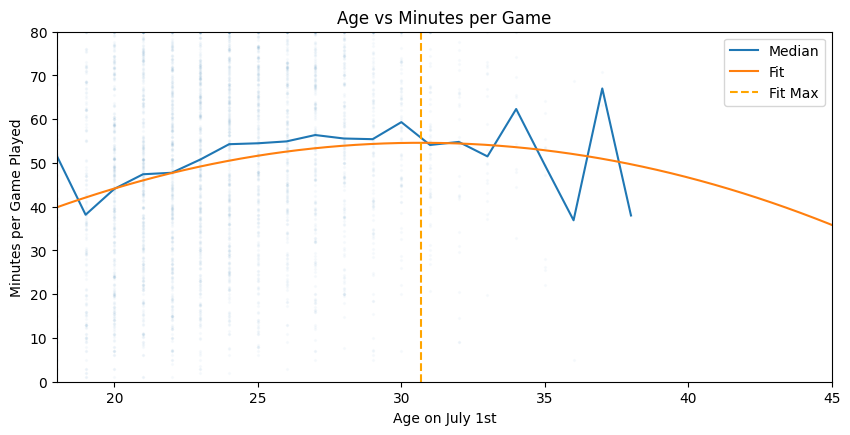

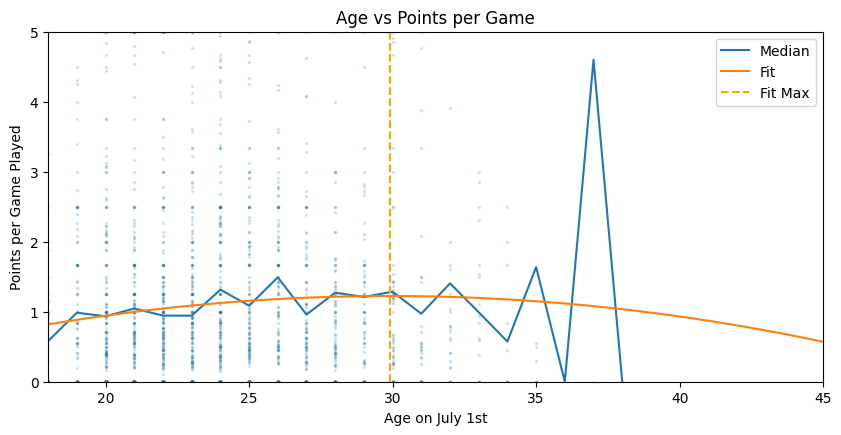

In [261]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
#plt.xlim([18, 42])
plt.ylim([0,80])
plt.xlim([18,45])
#plt.figure(2)
plt.plot(players_df.groupby('age').median()['min_avg'])
#plt.xlim([18,50])
X = np.array(players_df['age'])
y = np.array(players_df['min_avg'])
idx = np.isfinite(X) & np.isfinite(y)
fit = np.polyfit(X[idx],y[idx],2)
#plt.figure(3)
#print(fit)
X_fit = np.arange(15, 50, .1)
y_fit = (X_fit**2)*fit[0] + X_fit*fit[1] + fit[2]
plt.plot(X_fit, y_fit)
plt.plot([X_fit[y_fit.argmax()], X_fit[y_fit.argmax()]], [0,80], linestyle = '--', c='orange')
plt.legend(['Median', 'Fit', 'Fit Max'])
plt.scatter(players_df['age'], players_df['min_avg'], alpha = .025, s=2)
plt.xlabel('Age on July 1st')
plt.ylabel('Minutes per Game Played')
plt.title('Age vs Minutes per Game')
plt.show()
age_peak = X_fit[y_fit.argmax()]

plt.figure(figsize=(10,10))
plt.subplot(2,1,2)
#plt.xlim([18, 42])
plt.ylim([0,5])
#plt.figure(2)
plt.plot(players_df.groupby('age').mean()['pts_avg'])
#plt.xlim([18,50])
X = np.array(players_df['age'])
y = np.array(players_df['pts_avg'])
idx = np.isfinite(X) & np.isfinite(y)
fit = np.polyfit(X[idx],y[idx],2)
#plt.figure(3)
#print(fit)
X_fit = np.arange(15, 50, .1)
y_fit = (X_fit**2)*fit[0] + X_fit*fit[1] + fit[2]
plt.plot(X_fit, y_fit)
plt.plot([X_fit[y_fit.argmax()], X_fit[y_fit.argmax()]], [0,10], linestyle = '--', c='orange')
plt.legend(['Median', 'Fit', 'Fit Max'])
plt.scatter(players_df['age'], players_df['pts_avg'], alpha = .15, s=2)
plt.xlabel('Age on July 1st')
plt.ylabel('Points per Game Played')
plt.title('Age vs Points per Game')
plt.xlim([18, 45])
age_peak = X_fit[y_fit.argmax()]

In [171]:
columns = list(players_df.columns)
players_df = players_df[players_df['league_change']]
removals = ['age_pred', 'player_id', 'birthdate', 'pos', 'year', 'team', 'pts', 'played', 'start', 'try', 'pen', 'dp', 'tr', 'yellow', 'red', 'min', 'prev_year_min', 'prev_year_played', 'min_avg', 'career_played', 'career_min', 'career_start', 'prev_year_start', 'league_change','career_start_avg',  'prev_year_start_avg', 'pts_avg']
for string in removals:
    columns.remove(string)
players_mod_df = players_df[columns]
players_mod_df.replace([np.inf, -np.inf], np.nan, inplace=True)
players_mod_df = players_mod_df.dropna(axis=0)


player_mod_y = (players_df['min_avg'] > players_df['prev_year_min_avg'])
age_base = np.where(players_df['age_pred'], 1, 0)
players_mod_df['age'] = players_mod_df['age']/52
players_mod_df['prev_year_min_avg'] = players_mod_df['prev_year_min_avg']/80
players_mod_df['career_min_avg'] = players_mod_df['career_min_avg']/80


38
18       0.423077
19       0.403846
20       0.384615
25       0.634615
27       0.596154
           ...   
51032    0.442308
51045    0.538462
51057    0.442308
51082    0.480769
51122    0.500000
Name: age, Length: 2860, dtype: float64
17 38 1.0 80.0 1.0 80.0


/var/folders/7v/_90wc0ds3jd2h03mn95j4sfc0000gn/T/ipykernel_1498/1234548988.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players_mod_df.replace([np.inf, -np.inf], np.nan, inplace=True)


In [173]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier

In [174]:
def param_opt(X, y, param_grid, model):
    param_grid_res = dict(param_grid)
    for key in param_grid_res.keys():
        param_grid_res[key] = []
    for i in range(100):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30)
        grid = GridSearchCV(model, param_grid, refit = True, verbose = 0, n_jobs=8)
        grid.fit(X_train, y_train)
        for key, value in grid.best_params_.items():
            param_grid_res[key].append(value)
        if(i%10 == 0):
            print(i/100)
    return(pd.DataFrame.from_dict(param_grid_res))

In [175]:
def test_1000(X, y, model):

    test_acc = []
    train_acc = []
    baseline_acc = []
    for i in range(1000):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30)
        mod = model
        mod.fit(X_train, y_train)
        train_pred = mod.predict(X_train)
        test_pred = mod.predict(X_test)
        #print(accuracy_score(y_train, train_pred))
        #print(accuracy_score(y_test, test_pred))
        test_acc.append(accuracy_score(y_test, test_pred))
        train_acc.append(accuracy_score(y_train, train_pred))
        baseline_acc.append(1-np.mean(y_test))
        if(i%100 == 0):
            print(i/1000)
    test_acc_mean = np.mean(np.array(test_acc))
    train_acc_mean = np.mean(np.array(train_acc))
    #print(np.mean(np.array(baseline_acc)))
    test_base_mean = np.mean(np.array(test_acc)) - np.mean(np.array(baseline_acc))
    return(test_acc_mean, train_acc_mean, test_base_mean)

In [148]:
X = np.array(players_mod_df)
y = np.where(player_mod_y, 1, 0)
param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [ 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf', 'sigmoid', 'linear']}
svc_params = param_opt(X, y, param_grid, svm.SVC())
print(svc_params.groupby(svc_params.columns.tolist(), as_index = False).size())

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
       C   gamma   kernel  size
0      1  0.1000   linear     3
1     10  0.0100      rbf     1
2     10  0.1000   linear    14
3     10  0.1000  sigmoid     1
4    100  0.0100      rbf     7
5    100  0.0100  sigmoid     4
6    100  0.1000   linear    16
7    100  0.1000      rbf     1
8   1000  0.0001      rbf     1
9   1000  0.0010      rbf    10
10  1000  0.0010  sigmoid     2
11  1000  0.0100  sigmoid    29
12  1000  0.1000   linear    11


In [153]:
X = np.array(players_mod_df)
y = np.where(player_mod_y, 1, 0)
print(test_1000(X, y, svm.SVC(C = 1000, gamma = .1, kernel = 'linear')))
print(test_1000(X, y, svm.SVC(C = 1000, gamma = .01, kernel = 'sigmoid')))
print(test_1000(X, y, svm.SVC(C = 1000, gamma = .001, kernel = 'rbf')))
print(test_1000(X, y, svm.SVC(C = 100, gamma = .1, kernel = 'linear')))
print(test_1000(X, y, svm.SVC(C = 10, gamma = .1, kernel = 'linear')))


0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
(0.7309114219114219, 0.7393176823176822, 0.20985081585081589)
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
(0.7312668997668997, 0.7390654345654345, 0.2101993006993007)
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
(0.7294405594405595, 0.7391768231768232, 0.20819463869463883)
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
(0.7300850815850817, 0.7396463536463537, 0.20854895104895121)
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
(0.730932400932401, 0.7394325674325675, 0.20939510489510493)


In [221]:
from sklearn.utils import resample
from sklearn.utils import shuffle

In [222]:
def generate_sample(age, prev_year_min_avg, career_min_avg, competitions):
    career_min_avg_resample = shuffle(resample(career_min_avg, n_samples = 36000))
    prev_year_min_avg_resample = shuffle(resample(prev_year_min_avg, n_samples = 36000))
    age_resample = shuffle(resample(age, n_samples = 36000))
    
    random_players = np.empty(shape = (np.shape(competitions)[0]*4000, 5), dtype='object')

    for i in range(len(competitions)):
        random_players[i*4000:(i+1)*4000, 3] = competitions[i]
        #print(list(competitions).remove(competitions[i]))
        comp_temp = list(competitions)
        comp_temp.remove(competitions[i])
        #print(comp_temp)
        for j in range(len(comp_temp)):
            random_players[(i*4000)+(j*500):((i+1)*4000) + ((j+1)*500), 4] = comp_temp[j]
    random_players[:,0] = age_resample
    random_players[:,1] = prev_year_min_avg_resample
    random_players[:,2] = career_min_avg_resample
    
    index_values = np.arange(36000)
    column_names = ['age', 'prev_year_min_avg', 'career_min_avg', 'prev_year_competition', 'competition']
    random_players_df = pd.DataFrame(data = random_players, index = index_values, columns = column_names)
    #print(random_players_df)
    random_players_dum_df = pd.get_dummies(random_players_df, columns = ['prev_year_competition', 'competition'])
    random_players_arr = np.array(random_players_dum_df)
    
    return(random_players_arr, random_players_df)

In [226]:
def run_random_data(random_players_arr, X, y, model):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30)
    model.fit(X_train, y_train)
    test_pred = model.predict(X_test)
    random_players_pred = svc.predict(random_players_arr)
    return(random_players_pred)


In [238]:
X = np.array(players_mod_df)
y = np.where(player_mod_y, 1, 0)
results = np.zeros((25,36000))
for i in range(25):
    arr, df = generate_sample(players_mod_df['age'], players_mod_df['prev_year_min_avg'], players_mod_df['career_min_avg'], total_competitions)
    results[i,:] = run_random_data(arr, X, y, svm.SVC(C = 1000, gamma = .01, kernel = 'sigmoid'))
random_players_pred = np.mean(results, 0)

In [239]:
df['increase'] = random_players_pred
print(df.groupby('competition').mean())

                             increase
competition                          
Currie Cup                    0.45539
England Championship          0.56128
England Premiership           0.33957
NPC                           0.50435
National Rugby Championship   0.54157
Pro D2                        0.51007
Super Rugby                   0.34098
Top 14                        0.43901
United Rugby Championship     0.41916


| Competition                      | Pct. Increase in Minutes |
| :------------------------------- | :----------------------- |
| England Premiership              | 34.0%                    |
| Super Rugby                      | 34.1%                    |
| United Rugby Championship        | 41.9%                    |
| Top 14                           | 43.9%                    |
| Currie Cup                       | 45.5%                    |
| National Provincial Championship | 50.4%                    |
| Pro D2                           | 51.0%                    |
| National Rugby Championship      | 54.1%                    |
| England Championship             | 56.1%                    |

### Intro
### Scrape league data - Check
### Show scoring trend - Check
### Scrape player data - Check
### Format player data - Check
### Show age analysis - Check
### Model minutes predictions - Check
### Generate player test set - Check
### Show league rankings - Check

# To Do

### Turn final analysis into a loop of about 10 models - Check


### Explore scoring vs age trend

### Add extra baseline using just age to predict minutes

### Markdown